In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scipy

In [4]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import scipy


2024-05-28 06:37:08.332160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 06:37:08.399987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 06:37:08.401673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 06:37:09.618077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Tentukan jalur sumber dan tujuan
source_path = './'  # Ganti dengan jalur yang benar

In [6]:
root_dir = os.path.expanduser('~/food') #BISA DIATUR SENDIRI BUAT LOKASI DARI FILE TRAINING DAN VALIDATION#

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):

  #Creates directories for the train and test sets

  os.makedirs(root_path, exist_ok=True)
  train_dir = os.path.join(root_path, 'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path, 'testing')

  items =  ['Apple', 'Banana','Fried_Chicken','Beef_Rendang','Egg','Doughnut']
  for x in items:
    os.makedirs(os.path.join(train_dir, x), exist_ok=True)
    os.makedirs(os.path.join(val_dir, x), exist_ok=True)
    os.makedirs(os.path.join(test_dir, x), exist_ok=True)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [7]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE, SPLIT_SIZE_TEST):
  file_list = [os.path.join(SOURCE_DIR, file) for file in os.listdir(SOURCE_DIR) if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0]

  train_num_items = int(round(len(file_list) * SPLIT_SIZE))
  train_list = random.sample(file_list, train_num_items)
  remain_list = list(set(file_list) - set(train_list))
  test_num_items = int(round(len(remain_list) * SPLIT_SIZE_TEST/(1-SPLIT_SIZE)))
  test_list = random.sample(remain_list, test_num_items)
  val_list = list(set(remain_list) - set(test_list))


  for f in train_list:
    copyfile(f, os.path.join(TRAINING_DIR, os.path.basename(f)))
  for f in test_list:
    copyfile(f, os.path.join(TESTING_DIR, os.path.basename(f)))
  for f in val_list:
    copyfile(f, os.path.join(VALIDATION_DIR, os.path.basename(f)))


In [8]:
TRAINING_DIR = os.path.join(root_dir, "training")
VALIDATION_DIR = os.path.join(root_dir, "validation")
TESTING_DIR = os.path.join(root_dir, "testing")
items =  ['Fried_Chicken','Beef_Rendang','Apple','Banana','Egg','Doughnut']

for food in items:
    SOURCE_DIR_FOOD = os.path.join(source_path, food)
    TRAINING_FOOD_DIR = os.path.join(TRAINING_DIR, food)
    VALIDATION_FOOD_DIR = os.path.join(VALIDATION_DIR, food)
    TESTING_FOOD_DIR = os.path.join(TESTING_DIR, food)

    for dir_path in [TRAINING_FOOD_DIR, VALIDATION_FOOD_DIR, TESTING_FOOD_DIR]:
        for file in os.scandir(dir_path):
            os.remove(file.path)

    # Define proportion of images used for training
    split_data(SOURCE_DIR_FOOD, TRAINING_FOOD_DIR, VALIDATION_FOOD_DIR, TESTING_FOOD_DIR, 0.8, 0.1)

    print(f"\n\nOriginal {food}'s directory has {len(os.listdir(SOURCE_DIR_FOOD))} images")


    # Training and validation splits
    print(f"There are {len(os.listdir(TRAINING_FOOD_DIR))} images of {food} for training")
    print(f"There are {len(os.listdir(VALIDATION_FOOD_DIR))} images of {food} for validation")
    print(f"There are {len(os.listdir(TESTING_FOOD_DIR))} images of {food} for testing")



Original Fried_Chicken's directory has 100 images
There are 80 images of Fried_Chicken for training
There are 10 images of Fried_Chicken for validation
There are 10 images of Fried_Chicken for testing


Original Beef_Rendang's directory has 100 images
There are 80 images of Beef_Rendang for training
There are 10 images of Beef_Rendang for validation
There are 10 images of Beef_Rendang for testing


Original Apple's directory has 100 images
There are 80 images of Apple for training
There are 10 images of Apple for validation
There are 10 images of Apple for testing


Original Banana's directory has 100 images
There are 80 images of Banana for training
There are 10 images of Banana for validation
There are 10 images of Banana for testing


Original Egg's directory has 100 images
There are 80 images of Egg for training
There are 10 images of Egg for validation
There are 10 images of Egg for testing


Original Doughnut's directory has 100 images
There are 80 images of Doughnut for traini

In [9]:
# Define the desired image size
target_size = (128, 128)  #ukuran foto yang ditraining dari dataset untuk menjadi model.

# nge training dataset menjadi categorical
# akan ditraining dr 5 foto misalkan menjadi 15 foto, jadi fotonya ditraining dari angle yg berbeda agar lebih akurat.
# Load the images from the train and test directories
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=10, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.1, zoom_range=0.3, horizontal_flip=True, fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

testing_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
testing_generator = testing_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

Found 480 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=target_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=target_size + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator)

Epoch 1/100
15/15 [==============================] - 13s 656ms/step - loss: 2.2983 - accuracy: 0.1979 - val_loss: 2.2757 - val_accuracy: 0.1667
Epoch 2/100
15/15 [==============================] - 8s 530ms/step - loss: 1.9682 - accuracy: 0.2542 - val_loss: 1.9801 - val_accuracy: 0.2167
Epoch 3/100
15/15 [==============================] - 9s 562ms/step - loss: 1.7194 - accuracy: 0.2958 - val_loss: 1.7524 - val_accuracy: 0.2667
Epoch 4/100
15/15 [==============================] - 9s 566ms/step - loss: 1.5112 - accuracy: 0.4000 - val_loss: 1.5833 - val_accuracy: 0.3167
Epoch 5/100
15/15 [==============================] - 14s 916ms/step - loss: 1.4086 - accuracy: 0.4458 - val_loss: 1.4316 - val_accuracy: 0.3167
Epoch 6/100
15/15 [==============================] - 8s 529ms/step - loss: 1.2788 - accuracy: 0.4917 - val_loss: 1.2919 - val_accuracy: 0.3833
Epoch 7/100
15/15 [==============================] - 9s 563ms/step - loss: 1.2056 - accuracy: 0.5312 - val_loss: 1.1777 - val_accuracy: 0.45

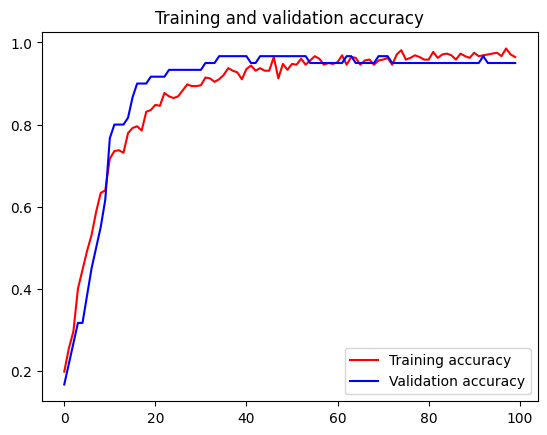

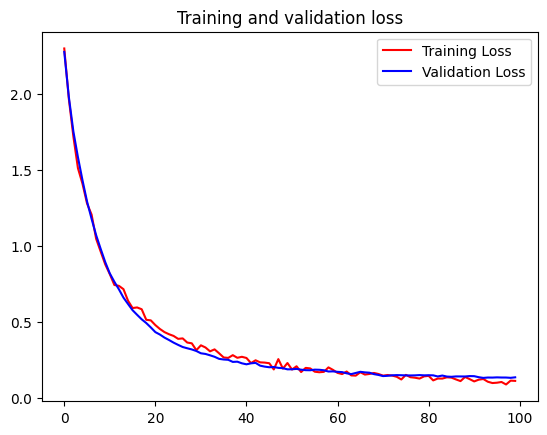

In [20]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
!pip install h5py
import h5py

# Saving the trained model as a Keras H5 file.
saved_model_path = "./model_products-1102.h5"
model.save(saved_model_path)

/home/c013d4ky0525/project/volume/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Loading the saved model
loaded_model = tf.keras.models.load_model("./model_products-1102.h5")

In [24]:
# Evaluation
results = loaded_model.evaluate(testing_generator, batch_size=32)
print("test loss, test acc:", results)

2/2 [==============================] - 2s 321ms/step - loss: 2.6620 - accuracy: 0.1333
test loss, test acc: [2.662003517150879, 0.13333334028720856]


In [25]:
import pickle

# Saving the model as a binary file using pickle
with open('model_products02.bin', 'wb') as f:
    pickle.dump(model, f)
